In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import sys
import warnings

warnings.filterwarnings('ignore')

from analysis import (
	find_thresholds,
	fit_gaussian,
	channel_props,
	human_training_accuracy,
	human_accuracy_matrix,
)

In [5]:
# LOAD DATA FROM ALL FILES IN THE ROOT FOLDER. IF ONE FILE CONTAINS MULTIPLE SUBJECTS, THEN ALL OF THEM WILL BE LOADED.
human_data_path = "../data/human_data.txt"
dfs = []
with open(human_data_path, 'r') as f:
	lines = f.readlines()
	for l in lines:
		# write into temp file if valid
		if l.startswith('['):
			with open("temp.txt", "w") as temp_file:
				temp_file.write(l)
		with open("temp.txt", "r") as temp_file:
			dfs.append(pd.read_json(temp_file, orient='records'))
	os.remove("temp.txt")

dfs[0].head()

,url,meta,sender,sender_type,sender_id,do-you-agree-to-participate-and-are-you-above-18-years-old.-undefined,what-describes-you-best-(male-female-others-prefer-not-to-say),please-enter-your-age-in-years.-(digits-only),do-you-need-glassescontact-lenses-to-read,are-you-wearing-them-(put-,...,time_switch,response,response_action,parameter0,looper,category,mode,filename,correctResponse,correct
0,{'srid': '3032'},"{'labjs_version': '20.2.4', 'labjs_build': {'f...",Agreement,html.Page,0.0,1.0,Female,30.0,no,NA,...,73360.690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,Training Instructions,html.Page,1.0,NaN,NaN,NaN,NaN,NaN,...,77676.184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,ScreenTraining,canvas.Screen,2.0,NaN,NaN,NaN,NaN,NaN,...,80758.657,click,click @fixation,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,Stimulus & Response,html.Screen,300.0,NaN,NaN,NaN,NaN,NaN,...,88973.207,oven,click button#oven,1.0,0.0,clock,noise0.16freq4,18_cbm_noise0.16_freq4_gray_g_clock.JPEG,clock,0.0
4,NaN,NaN,inter-stimulus,canvas.Screen,301.0,NaN,NaN,NaN,NaN,NaN,...,90072.894,click,click @fixation,1.0,0.0,NaN,NaN,NaN,NaN,NaN


In [6]:
# iterate through rows of df and store stim response record for each in appropriate block
def get_start_index(df, blockname):
	return df.loc[df['sender'] == "Screen" + blockname].index[0]

all_start_indices = []
for df in dfs:
	# get all start indices
	train_idx = get_start_index(df, "Training")
	test0_idx = get_start_index(df, "0")
	test1_idx = get_start_index(df, "1")
	test2_idx = get_start_index(df, "2")
	test3_idx = get_start_index(df, "3")
	test4_idx = get_start_index(df, "4")
	start_indices = [train_idx, test0_idx, test1_idx, test2_idx, test3_idx, test4_idx]

	all_start_indices.append(start_indices)
	print(df['url'][0], start_indices)

{'srid': '3032'} [2, 155, 788, 1421, 2054, 2687]
{'srid': '3026'} [2, 155, 788, 1421, 2054, 2687]
{'srid': '3025'} [2, 155, 788, 1421, 2054, 2687]
{'srid': '3024'} [2, 155, 788, 1421, 2054, 2687]
{'srid': '3038'} [2, 155, 788, 1421, 2054, 2687]
{'srid': '3037'} [2, 155, 788, 1421, 2054, 2687]
{'srid': '3035'} [2, 155, 788, 1421, 2054, 2687]
{'srid': '3034'} [2, 155, 788, 1421, 2054, 2687]
{'srid': '3033'} [2, 155, 788, 1421, 2054, 2687]
{'srid': '3046'} [2, 155, 788, 1421, 2054, 2687]
{'srid': '3045'} [2, 155, 788, 1421, 2054, 2687]
{'srid': '3044'} [2, 155, 788, 1421, 2054, 2687]
{'srid': '3042'} [2, 155, 788, 1421, 2054, 2687]
{'srid': '3041'} [2, 155, 788, 1421, 2054, 2687]


In [7]:
# Store stimulus response data (after skipping first 10 rows) for each timed block
# blocks = ["cattut", "motortime", "0", "400", "600", "800", "1000"]
blocks = ["training", "0", "1", "2", "3", "4"]
blocked_datas = []

def get_sr_block_data(df, start_idx, n_samples, n_skip=0):
	block_df = df.iloc[start_idx:start_idx + n_samples + 1]
	return block_df[block_df["sender"] == "Stimulus & Response"][n_skip:]

for i, df in enumerate(dfs):
	blocked_data = {}

	for j, block in enumerate(blocks):
		if block == "training":
			blocked_data[block] = get_sr_block_data(df, all_start_indices[i][j], 50*3)

		else:
			blocked_data[block] = get_sr_block_data(df, all_start_indices[i][j], 210*3)

	blocked_datas.append(blocked_data)

In [8]:
# Replace all NaN values with random category
categories = ["airplane", 'bear', 'bicycle', 'bird', 'boat', 'bottle', 'car', 'cat', 'chair', 'clock', 'dog', 
	       'elephant', 'keyboard', 'knife', 'oven', 'truck']
for i, blocked_data in enumerate(blocked_datas):
	for j, block in enumerate(blocks[1:]):
		response_idx = blocked_data[block].columns.get_loc("response")
		b = blocked_data[block].values
		n = b[:, response_idx].astype(str) == 'nan'
		b[:, response_idx][n] = np.random.choice(categories, size=np.sum(n))
		blocked_datas[i][block] = pd.DataFrame(b, columns=blocked_data[block].columns)

In [9]:
# Compute training accuracy
cat_accs = human_training_accuracy(blocked_datas, dfs)

{'srid': '3032'}: Accuracy on training block: 60.0 %
{'srid': '3026'}: Accuracy on training block: 82.0 %
{'srid': '3025'}: Accuracy on training block: 84.0 %
{'srid': '3024'}: Accuracy on training block: 84.0 %
{'srid': '3038'}: Accuracy on training block: 88.0 %
{'srid': '3037'}: Accuracy on training block: 88.0 %
{'srid': '3035'}: Accuracy on training block: 84.0 %
{'srid': '3034'}: Accuracy on training block: 80.0 %
{'srid': '3033'}: Accuracy on training block: 88.0 %
{'srid': '3046'}: Accuracy on training block: 90.0 %
{'srid': '3045'}: Accuracy on training block: 86.0 %
{'srid': '3044'}: Accuracy on training block: 84.0 %
{'srid': '3042'}: Accuracy on training block: 82.0 %
{'srid': '3041'}: Accuracy on training block: 88.0 %


In [10]:
# GET HUMAN ACCURACY MATRIX
final_mat, acc_matrices = human_accuracy_matrix(blocked_datas)

In [11]:
# INDIVIDUAL HEATMAPS
bws, cfs, pnss = [], [], []
for am in acc_matrices:
	thresholds = find_thresholds(am)
	hist_fit, (A, mu, sigma) = fit_gaussian(thresholds, vb=False)
	bw, cf, pns = channel_props(A, mu, sigma, vb=False)
	bws.append(bw)
	cfs.append(cf)
	pnss.append(pns)
print("BW: {:.2f}, {:.2f}, CF: {:.2f}, {:.2f}, PNS: {:.2f}, {:.2f}".format(
	np.mean(bws), np.std(bws),
	np.mean(cfs), np.std(cfs),
	np.mean(pnss), np.std(pnss)
))

BW: 1.43, 0.54, CF: 39.13, 2.98, PNS: 0.80, 0.28


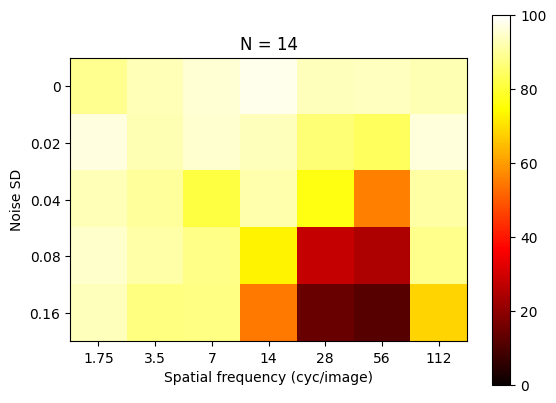

In [9]:
# AVERAGE HEATMAP
# Plot accuracy for each noise-sf combination
noise_list = list(map(str, [0, 0.02, 0.04, 0.08, 0.16]))
freq_list = list(map(str, range(7)))

cpi_list = list(map(str, [1.75, 3.5, 7, 14, 28, 56, 112]))
fig, ax = plt.subplots()

ax.set_xticks(np.arange(len(cpi_list)))
ax.set_xticklabels(cpi_list)

ax.set_yticks(np.arange(len(noise_list)))
ax.set_yticklabels(noise_list)

im = ax.imshow(final_mat, cmap='hot', interpolation='nearest', vmin=0, vmax=100)
fig.colorbar(im, ax=ax)
plt.xlabel('Spatial frequency (cyc/image)')
plt.ylabel('Noise SD')
plt.title(f"N = {len(blocked_datas)}")
plt.show()


In [10]:
thresholds = find_thresholds(final_mat, 50)
thresholds

array([0, 0, 0, 0, 2, 2, 0])

fit_gaussian coeffs: A = 4.00, mu = 4.50, sigma = 0.42

channel_props:
BW: 1.00 octaves,
CF: 39.60 cycles/image,
PNS: 1.00 per unit SD



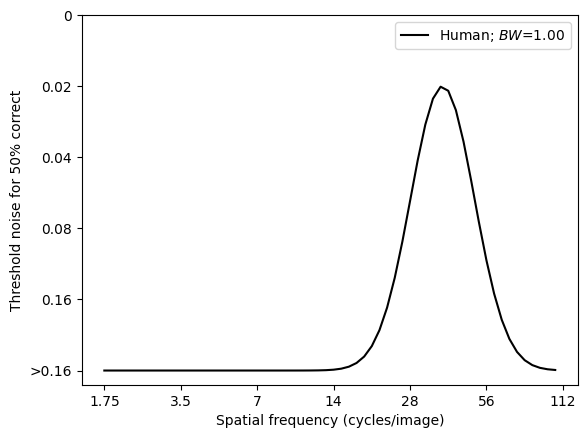

In [11]:
gauss_fit, (A, mu, sigma) = fit_gaussian(thresholds)
bw, cf, pns = channel_props(A, mu, sigma)

fig, ax = plt.subplots()
x = np.arange(0, 6, 6/60)
ax.plot(x, gauss_fit, color='black', label="{}; $BW$={:.2f}".format("Human", bw))
thresvar_list = noise_list + [">0.16"]
ax.set_yticks(np.arange(len(thresvar_list)))

xtl = ax.get_xticklabels()
xtl[1:-1] = cpi_list
ax.set_xticklabels(xtl)
ytl = ax.get_yticklabels()
ytl = reversed(thresvar_list)
ax.set_yticklabels(ytl)
ax.set_xlabel("Spatial frequency (cycles/image)")
ax.set_ylabel(f"Threshold noise for 50% correct")
plt.legend()
plt.show()